In [1]:
!python -m pip install grandalf


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from typing import Literal
from langchain_openai import ChatOpenAI
from langgraph.types import Command
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from langchain_core.tools import StructuredTool
from langchain_core.messages import ToolMessage, SystemMessage

model = ChatOpenAI(model='gpt-4.1-mini')


@tool
def execute_python_code(code: str) -> str:
   """Execute generated python code. Use print() to output the result: e.g. print(1+1)"""
   return exec(code)

@tool
def get_weather(city: str) -> str:
   """Get the weather of a city."""
   return f"The weather in {city} is sunny"

agents = {
    'weather_agent': (
        model,
        [get_weather],
        'weather_agent is capable of getting the weather of a city',
        "You are the 'weather_agent'. You are capable of getting the weather of a city."
    ),
    'python_agent': (
        model,
        [execute_python_code],
        'python_agent is capable of executing python code',
        "You are the 'python_agent'. You are capable of executing python code."
    )    
}


def pass_to_agent_func(agent_name: str) -> str:
    """Pass the message history to the next agent to continue the conversation."""
    return f"Passing the message to {agent_name}"

pass_to_agent = StructuredTool.from_function(
    func=pass_to_agent_func,
    name="pass_to_agent",
    description=f"""Pass the message history to the next agent to continue the conversation.

    There are {len(agents)} agents available: {", ".join(agents.keys())}
    
    The agents are:
    {agents}
    """
)

for agent_name, (model, tools, description, system_prompt) in agents.items():
    tools.append(pass_to_agent)

class NetworkState(MessagesState):
    current_agent: str
    
def create_agent_node(agent_name: str):
    def agent_function(state: NetworkState):
        (model, tools, description, system_prompt) = agents[agent_name]
        print(f'Passing {len(state["messages"])} messages to {agent_name}')
        response = model.bind_tools(tools).invoke(
            [SystemMessage(content=system_prompt)] + state['messages']
            )
        # print(f'{agent_name} response: {response}')
        # check for tool call to pass to next agent
        tool_calls = response.tool_calls
        if tool_calls:
            for tool_call in tool_calls:
                if tool_call.get("name") == "pass_to_agent":
                    next_agent = tool_call["args"]["agent_name"]
                    return Command(
                        goto=next_agent,
                        update={"messages": [response, ToolMessage(tool_call_id=tool_call["id"], content=f'Successfully passed to {next_agent}')]}
                    )
                else:
                    tool_messages = []
                    # run the actual tool
                    tool_name = tool_call["name"]
                    tool_input = tool_call["args"]
                    for tool in tools:
                        if tool.name == tool_name:
                            tool_result = tool.invoke(tool_input)
                            tool_messages.append(ToolMessage(tool_call_id=tool_call["id"], content=tool_result))
                    return Command(
                        goto=agent_name,
                        update={"messages": [response, *tool_messages]}
                    )
        else:
            return Command(
                goto=END,
                update={"messages": response}
            )
    return agent_function

builder = StateGraph(NetworkState)
for agent_name, (model, tools, description, system_prompt) in agents.items():
    builder.add_node(agent_name, create_agent_node(agent_name))

builder.add_edge(START, "weather_agent")
network = builder.compile()

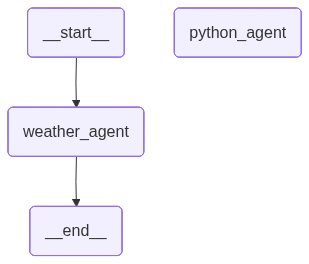

In [3]:
from IPython.display import Image, display
try:
    png_data = network.get_graph().draw_mermaid_png()
    display(Image(png_data))
except Exception as e:
    print(network.get_graph().draw_ascii())


In [4]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage

def print_event(event):
    """Pretty print network events with emojis and better formatting"""
    for agent_name, data in event.items():
        print(f"\n🤖 Agent: {agent_name}")
        
        if 'messages' in data:
            messages = data['messages']
            if isinstance(messages, list):
                for msg in messages:
                    if isinstance(msg, AIMessage):
                        if msg.content:
                            print(f"💬 Response: {msg.content}")
                        if hasattr(msg, 'tool_calls') and msg.tool_calls:
                            for tool_call in msg.tool_calls:
                                if tool_call['name'] == 'pass_to_agent':
                                    print(f"🔄 Passing to: {tool_call['args']['agent_name']}")
                                elif tool_call['name'] == 'get_weather':
                                    print(f"🌤️ Getting weather for: {tool_call['args']['city']}")
                                elif tool_call['name'] == 'execute_python_code':
                                    print(f"🐍 Executing Python code:")
                                    code = tool_call['args']['code']
                                    # Format code nicely
                                    for line in code.split('\n'):
                                        print(f"    {line}")
                                else:
                                    print(f"🔧 Tool call: {tool_call['name']} with {tool_call['args']}")
                    elif isinstance(msg, ToolMessage):
                        if msg.content != 'None':
                            print(f"⚙️ Tool result: {msg.content}")
            else:
                if isinstance(messages, AIMessage):
                    if messages.content:
                        print(f"💬 Response: {messages.content}")

for event in network.stream({"messages": [
    HumanMessage(content="What is the weather in Tokyo? Once you have the weather, write python code to calculate the reverse of the weather in Tokyo.")
]}):
    print_event(event)

Passing 1 messages to weather_agent

🤖 Agent: weather_agent
🌤️ Getting weather for: Tokyo
⚙️ Tool result: The weather in Tokyo is sunny
Passing 3 messages to weather_agent

🤖 Agent: weather_agent
💬 Response: The weather in Tokyo is sunny.

Now, I will write python code to calculate the reverse of the word "sunny".
🔄 Passing to: python_agent
⚙️ Tool result: Successfully passed to python_agent
Passing 5 messages to python_agent
ynnus

🤖 Agent: python_agent
🐍 Executing Python code:
    weather = "sunny"
    reversed_weather = weather[::-1]
    print(reversed_weather)
Passing 7 messages to python_agent

🤖 Agent: python_agent
💬 Response: The reverse of the weather word "sunny" is "ynnus". If you have any other questions or need further assistance, feel free to ask!
